In [1]:
import cvxpy as cp
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import itertools
import casadi as ca

from __future__ import annotations
import math
from typing import Tuple, List
from numpy.linalg import solve, norm

In [2]:
def fluid_value(T, N, lam, y0, steady_state = False, steady_control = False):
    #b = (N+ np.sqrt(lam))**2
    
    u = ca.MX.sym('u', T)
    y = ca.MX.sym('y', T+1)
    
    # objective

    J = 0
    for t in range(T):
        J += N**2/(1-u[t]) + y[t] #-b
    J = (J) #+ y[T]

    # constraints list
    g = []
    # initial condition
    g.append(y[0] - y0)
    # dynamics
    if steady_state:
        for t in range(T):
            g.append(y[t+1] - y[t])
    else:    
        for t in range(T):
            g.append(y[t+1] - (y[t] + lam - u[t]*y[t]))
            
    # pack into NLP
    w   = ca.vertcat(u, y)
    nlp = {'x': w, 'f': J, 'g': ca.vertcat(*g)}
    opts = {'ipopt.print_level': 0, 'print_time': 0}
    solver = ca.nlpsol('S', 'ipopt', nlp, opts)

    # bounds
    lbg = [0]*len(g)         # dynamics = 0, init = 0
    ubg = [0]*len(g)
    if steady_control:
        u_fix = np.sqrt(lam)/(N+np.sqrt(lam))
        lbx = [u_fix]*T     + [0]*(T+1) 
        ubx = [u_fix]*T     + [1e6]*(T+1)
    else:
        lbx = [0]*T + [0]*(T+1)  # u >= 0, y >= 0
        ubx = [1]*T + [1e6]*(T+1)
    
    # solve
    res = solver(lbx=lbx, ubx=ubx, lbg=lbg, ubg=ubg)
    w_opt = res['x'].full().flatten()
    u_opt = w_opt[:T]
    y_opt = w_opt[T:]
    return float(res['f']), u_opt, y_opt

def fluid_value_eval(T, N, lam, y0, u_opt, y_opt, drop=0.0):
    J = 0
    for t in range(int((1-drop)*T)):
        J += N**2/(1-u_opt[t]) + y_opt[t] #-b
    return J
    

def fluid_array(T, N, lam_values, upper_bound_capacity):
    #Solve the deterministic version of the multi-secretary problem for all periods in approx_periods and all capacities
    capacities = np.arange(0, upper_bound_capacity + 1, 1)
    val_deterministic = np.zeros((len(lam_values), capacities.shape[0]))
    solution_deterministic = np.zeros((len(lam_values), capacities.shape[0], T))
    states_deterministic = np.zeros((len(lam_values), capacities.shape[0], T+1))
    for indx, lam in enumerate(lam_values):
        for indx_cap, x in tqdm(enumerate(capacities)):
            val_deterministic[indx, indx_cap], solution_deterministic[indx, indx_cap, :], states_deterministic[indx, indx_cap, :] = fluid_value(T, N, lam, x)
            
    return val_deterministic, solution_deterministic, states_deterministic


################################################################################
# Utility: binomial coefficient tables
################################################################################

def build_binom_tables(S_max: int) -> List[List[int]]:
    """Return a triangular table C[n][k] = binom(n,k) for n≤S_max."""
    C = [[1]]
    for n in range(1, S_max + 1):
        row = [1]
        for k in range(1, n):
            row.append(C[n - 1][k - 1] + C[n - 1][k])
        row.append(1)
        C.append(row)
    return C

################################################################################
# Golden‑section search on [a,b]
################################################################################

def golden_section_minimize(f, a: float, b: float, tol: float = 1e-9, max_it: int = 100) -> Tuple[float, float]:
    """Minimise *unimodal* f on [a,b] via golden‑section search.

    Returns `(argmin, f(argmin))`."""
    phi = (1 + 5 ** 0.5) / 2  # golden ratio φ≈1.618
    invphi = 1 / phi          # 1/φ≈0.618

    c = b - invphi * (b - a)
    d = a + invphi * (b - a)
    fc = f(c)
    fd = f(d)

    for _ in range(max_it):
        if abs(b - a) < tol:
            break
        if fc < fd:
            b, d, fd = d, c, fc
            c = b - invphi * (b - a)
            fc = f(c)
        else:
            a, c, fc = c, d, fd
            d = a + invphi * (b - a)
            fd = f(d)
    u_star = 0.5 * (a + b)
    return u_star, f(u_star)

################################################################################
# value iteration with *continuous* control + history
################################################################################

def value_iteration(
    lam: float,
    N: float,
    S_max: int,
    tol: float = 1e-8,
    max_iter: int = 20_000,
    ref_state: int | None = 0,
    val_initial: np.ndarray | None = None
) -> Tuple[np.ndarray, float, np.ndarray, int, List[float], List[np.ndarray], np.ndarray]:
    """Differential cost iteration (continuous control) **with history**.

    Returns `u_star, g, h, it, g_hist, h_hist` where:
    * `g_hist[k]   = g_k` average‑cost estimate at iteration *k*;
    * `h_hist[k]   = h_k` differential cost **vector** at iteration *k*.
    """
    if not (0 < lam < 1):
        raise ValueError("λ must be in (0,1).")
    if ref_state is None:
        ref_state = 0

    S = S_max + 1
    value = val_initial if val_initial is not None else np.zeros(S)  # initial value function
    u_star = np.zeros(S)
    g = value[ref_state]   # average cost
    h = value - value[ref_state]  # differential cost vector
    # --- history containers ---
    g_hist: List[float] = []
    h_hist: List[np.ndarray] = []

    # Pre‑compute binomial coefficients
    Cnk = build_binom_tables(S_max)
    eps_u = 1e-10  # guard against u→1

    for it in range(1, max_iter + 1):
        value_new = np.zeros(S)  # new differential cost vector

        # ----- Bellman minimisation over u ∈ [0,1) for each x -----
        for x in range(S):
            def Q(u: float) -> float:
                one_minus_u = 1.0 - u/N
                inv_one_minus_u = N ** 2 / one_minus_u  # part of cost plus exp terms

                # Expected continuation cost
                pow_u = 1.0  # u^d incrementally
                exp_val = 0.0
                for d in range(x + 1):
                    if d > 0:
                        pow_u *= u/N
                    prob = Cnk[x][d] * pow_u * (one_minus_u ** (x - d))
                    idx_arr1 = min(x + 1 - d, S_max)  # arrival=1
                    idx_arr0 = x - d                  # arrival=0
                    exp_val += prob * (lam * h[idx_arr1] + (1 - lam) * h[idx_arr0])
                return inv_one_minus_u + x  + exp_val

            u_opt, q_val = golden_section_minimize(Q, 0.0, N - eps_u)
            u_star[x] = u_opt
            value_new[x] = q_val

        # ----- Average‑cost update and normalisation -----
        #g_new = value_new[ref_state] - value[ref_state]
        #h_new = value_new - value_new[ref_state]
        g_new = value_new[ref_state] 
        h_new = value_new - value_new[ref_state]

        # ----- Save history -----
        g_hist.append(g_new)
        h_hist.append(h_new.copy())
        
        # ----- Convergence test -----
        if max(abs(g_new - g), np.max(np.abs(h_new - h)))  < tol:
            g = g_new
            break
        value = value_new
        g = g_new
        h = h_new
    else:
        it = max_iter

    return u_star, g, h, it, g_hist, h_hist, value_new

######################################################################
# Average-cost *policy evaluation*
######################################################################

def policy_evaluation(
    lam: float,
    N: float,
    S_max: int,
    u_pol: np.ndarray,
    tol: float = 1e-12,
    max_iter: int = 20_000,
) -> Tuple[float, np.ndarray]:
    """
    Solve   0 = c_pi - g*e + (P_pi - I) h,
    returning (g, h) for the given *continuous* control vector u_pol.

    Parameters
    ----------
    lam, N, S_max  :  model parameters (as in your value_iteration)
    u_pol          :  length‐(S_max+1) array with u_pol[x] ∈ [0,N)
    tol, max_iter  :  power-iteration settings for the stationary dist.

    Returns
    -------
    g : float           average cost under the policy
    h : (S_max+1,) ndarray   bias (differential cost) vector, normalised
                             so that the stationary distribution d satisfies d·h = 0.
    """

    if not (0 < lam < 1):
        raise ValueError("λ must be in (0,1).")
    S = S_max + 1
    if u_pol.shape != (S,):
        raise ValueError(f"`u_pol` must have length {S}.")

    # ---------- build cost vector c_pi and transition matrix P_pi ----------
    Cnk = build_binom_tables(S_max)
    P = np.zeros((S, S))
    c = np.zeros(S)

    for x in range(S):
        u = float(u_pol[x])
        if not (0.0 <= u < N):
            raise ValueError(f"u_pol[{x}]={u} must lie in [0, N).")

        one_minus_u = 1.0 - u / N
        c[x] = N**2 / one_minus_u + x            # immediate cost

        prob_d      = 1.0                        # (u/N)^d term
        for d in range(x + 1):
            if d:                                # update (u/N)^d incrementally
                prob_d *= u / N
            p_depart = Cnk[x][d] * prob_d * (one_minus_u ** (x - d))

            s0 = x - d                           # queue after d departures
            s1 = min(s0 + 1, S_max)              # +1 arrival

            P[x, s1] += lam * p_depart
            P[x, s0] += (1.0 - lam) * p_depart

    # ---------- stationary distribution d ----------
    d = np.ones(S) / S            # start uniform
    for _ in range(max_iter):
        d_next = d @ P
        if norm(d_next - d, 1) < tol:
            break
        d = d_next
    d /= d.sum()

    # ---------- average cost g ----------
    g = float(d @ c)

    # ---------- bias vector h  (Poisson equation) ----------
    I = np.eye(S)
    A = I - P + np.outer(np.ones(S), d)   # full-rank by construction
    b = c - g
    h = solve(A, b)

    # sanity-check  max|c - g - (P-I)h|
    resid = np.max(np.abs(c - g + (P @ h - h))) 
    if resid > 1e-8:
        print(f"Warning: Poisson residual {resid:.3e} exceeds tolerance.")

    return g, h, d



In [45]:
T = 500
N = 50
lam_values = .5 
upper_bound_capacity = 200
drop_factor = 0.3

In [46]:
lam = lam_values
stable_cost = (N + np.sqrt(lam))**2
print('stable cost: '+ str((N+ np.sqrt(lam))**2))
print('stable policy: '+ str(np.sqrt(lam)/(N+np.sqrt(lam))))
print('steady state: '+ str(np.sqrt(lam)*(N+np.sqrt(lam))))

stable cost: 2571.2106781186544
stable policy: 0.013944924608652683
steady state: 35.85533905932738


In [8]:
stable_state = np.sqrt(lam_values)*(N+np.sqrt(lam_values))
#capacities = np.array([stable_state])
capacities = np.arange(0, upper_bound_capacity + 1, 1)
val_fluid = np.zeros((capacities.shape[0]))
solution_fluid = np.zeros((capacities.shape[0], T))
states_fluid = np.zeros((capacities.shape[0], T+1))
val_steady_control = np.zeros((capacities.shape[0]))
solution_steady_control = np.zeros((capacities.shape[0], T))
states_steady_control = np.zeros((capacities.shape[0], T+1))
val_fluid_temp = np.zeros((capacities.shape[0]))

for indx_cap, x in tqdm(enumerate(capacities)):
    val_fluid_temp[indx_cap], solution_fluid[indx_cap, :], states_fluid[indx_cap, : ] = fluid_value(T, N, lam_values, x)
    val_fluid[indx_cap] = fluid_value_eval(T, N, lam_values, x, solution_fluid[indx_cap, :], states_fluid[indx_cap, :], drop = drop_factor)
    #val_steady_control[indx_cap], solution_steady_control[indx_cap, :], states_steady_control[indx_cap, : ] = fluid_value(T, N, lam_values, x, steady_control=True)

print("Fluid value:", val_fluid)
#print("Steady control value:", val_steady_control)

1it [00:00,  2.29it/s]


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



201it [01:07,  2.97it/s]

Fluid value: [896084.32168278 896226.24308817 896366.1644908  896504.08589073
 896640.00728805 896773.92868282 896905.85007513 897035.77146507
 897163.69285271 897289.61423813 897413.53562141 897535.45700263
 897655.37838188 897773.29975922 897889.22113475 898003.14250854
 898115.06388067 898224.98524997 898332.90662027 898438.82798791
 898542.7493542  898644.67071924 898744.5920831  898842.51344586
 898938.43480761 899032.35616841 899124.27752782 899214.19888707
 899302.12024562 899388.04160355 899471.96296115 899553.88431787
 899633.80567443 899711.72703078 899787.68297012 899861.77251238
 899934.09329504 900004.73534561 900073.78185967 900141.3098814
 900207.39090109 900272.09138116 900335.47322114 900397.59417001
 900458.50819235 900518.26579507 900576.91431921 900634.49820164
 900691.05921002 900746.63665419 900801.26757724 900854.98692786
 900907.82771707 900959.82115989 901010.99680459 901061.3826504
 901111.00525487 901159.88983209 901208.06034264 901255.53957608
 901302.349226

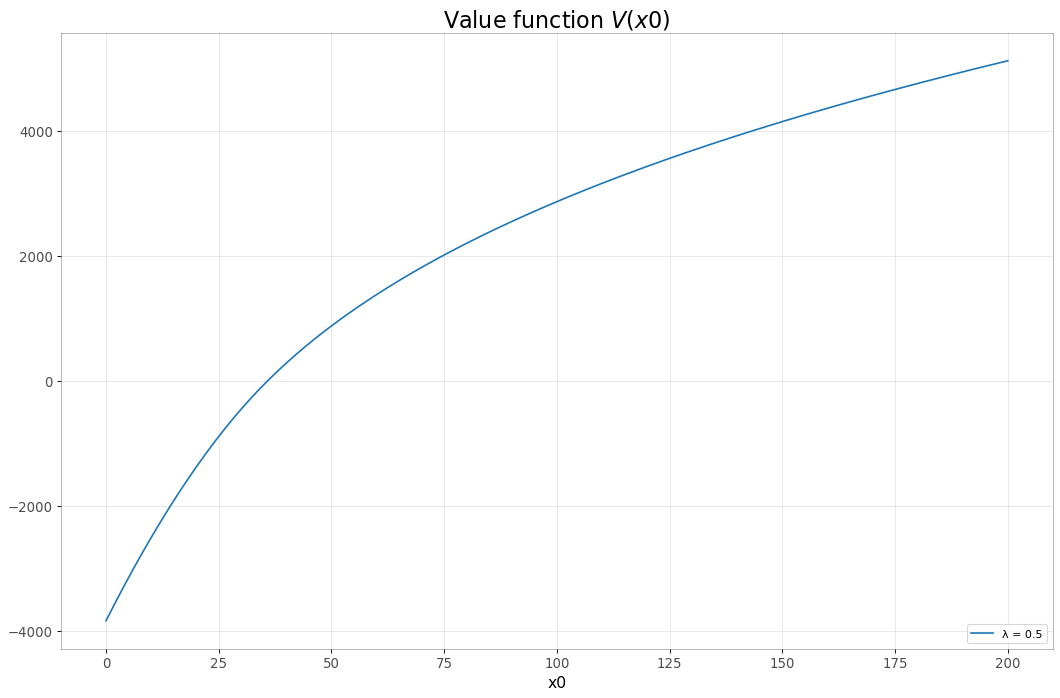

In [9]:
line_styles = itertools.cycle(['-', '--', '-.', ':'])
colors = itertools.cycle(['black', 'red', 'blue'])
plt.figure(figsize=(16,10), dpi= 80)
x=np.arange(0, upper_bound_capacity + 1, 1)
plt.plot(x[:], val_fluid[:] - (int((1-drop_factor)*T))*stable_cost, label=f'λ = {lam_values}', linestyle=next(line_styles), marker='', fillstyle='none')
# Decoration
plt.xticks(rotation=0, fontsize=12, horizontalalignment='center', alpha=.7)
plt.yticks(fontsize=12, alpha=.7)
plt.title('Value function $V(x0)$', fontsize=20)
plt.grid(axis='both', alpha=.3)
plt.xlabel('x0', fontsize = 14)
plt.gca().spines["top"].set_alpha(0.3)    
plt.gca().spines["bottom"].set_alpha(0.3)
plt.gca().spines["right"].set_alpha(0.3)    
plt.gca().spines["left"].set_alpha(0.3)   
plt.legend(loc = "lower right")
plt.show()
plt.close()

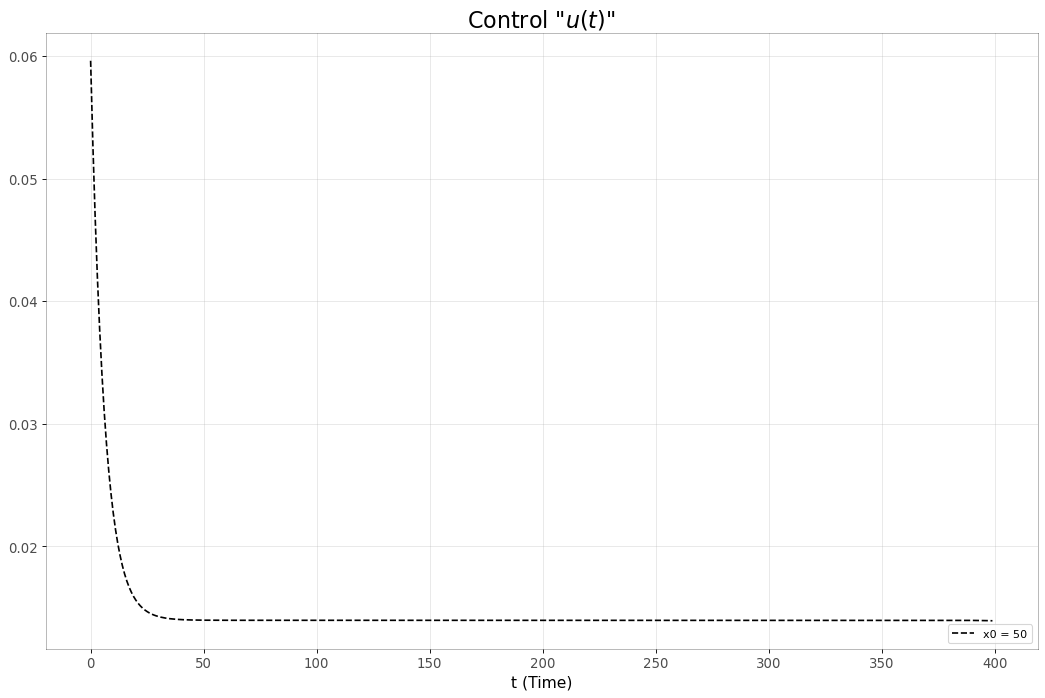

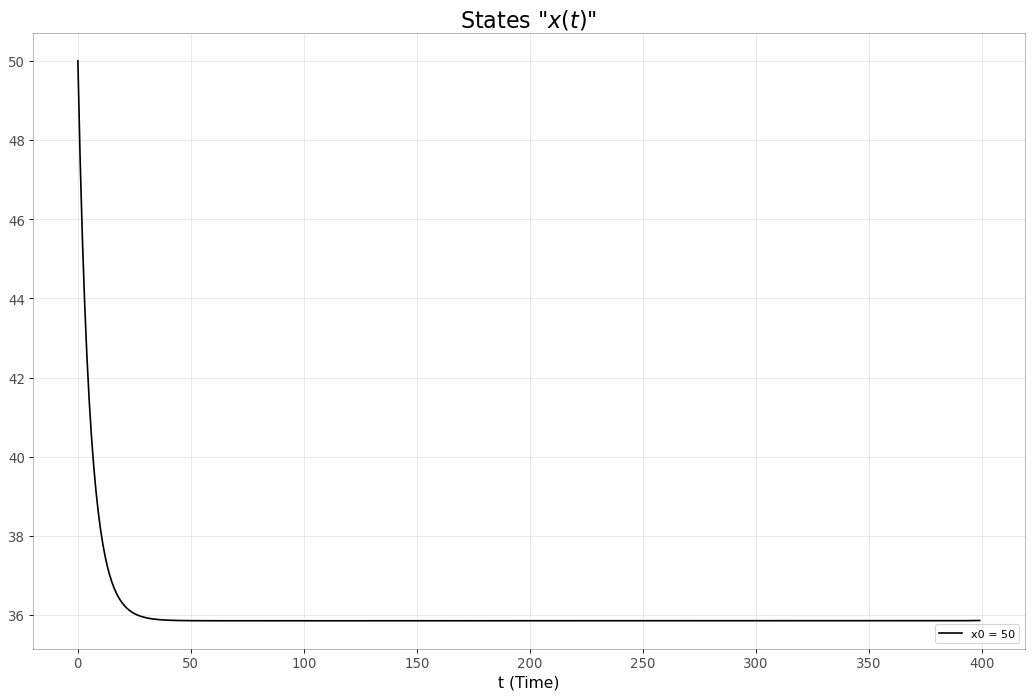

In [10]:
initial_state = 50
line_styles = itertools.cycle(['--', '-.', ':'])
colors = itertools.cycle(['black', 'red', 'blue'])
plt.figure(figsize=(16,10), dpi= 80)
plt.plot(solution_fluid[initial_state][:int(.8*T)], label=f'x0 = {initial_state}', linestyle=next(line_styles), marker='', fillstyle='none', color=next(colors))
#plt.plot(solution_steady_control[0][:50], label=f'Steady Control u = sqrt(lam)/N', linestyle=next(line_styles), marker='', fillstyle='none', color=next(colors))
plt.xlabel('t (Time)', fontsize = 14)
# Decoration
plt.xticks(rotation=0, fontsize=12, horizontalalignment='center', alpha=.7)
plt.yticks(fontsize=12, alpha=.7)
plt.title('Control "$u(t)$"', fontsize=20)
plt.grid(axis='both', alpha=.3)
plt.gca().spines["top"].set_alpha(0.3)    
plt.gca().spines["bottom"].set_alpha(0.3)
plt.gca().spines["right"].set_alpha(0.3)    
plt.gca().spines["left"].set_alpha(0.3)   
plt.legend(loc = "lower right")
plt.show()

line_styles = itertools.cycle(['-', '--', '-.', ':'])
colors = itertools.cycle(['black', 'red', 'blue'])
plt.figure(figsize=(16,10), dpi= 80)
plt.plot(states_fluid[initial_state][:int(.8*T)], label=f'x0 = {initial_state}', linestyle=next(line_styles), marker='', fillstyle='none', color=next(colors))
#plt.plot(states_steady_control[0][:50], label=f'Steady Control u = sqrt(lam)/N', linestyle=next(line_styles), marker='', fillstyle='none', color=next(colors))
plt.xlabel('t (Time)', fontsize = 14)
# Decoration
plt.xticks(rotation=0, fontsize=12, horizontalalignment='center', alpha=.7)
plt.yticks(fontsize=12, alpha=.7)
plt.title('States "$x(t)$"', fontsize=20)
plt.grid(axis='both', alpha=.3)
plt.gca().spines["top"].set_alpha(0.3)    
plt.gca().spines["bottom"].set_alpha(0.3)
plt.gca().spines["right"].set_alpha(0.3)    
plt.gca().spines["left"].set_alpha(0.3)   
plt.legend(loc = "lower right")
plt.show()


=== Continuous‑control Geom/Geom/∞ queue ===
Arrival probability λ    : 0.5
Optimal average cost g*  : 2570.568638
Iterations to converge   : 169

Optimal control u*(x) 
[3.39299106e-10 3.39299106e-10 3.39299106e-10 3.39299106e-10
 3.39299106e-10 3.39299106e-10 3.39299106e-10 3.39299106e-10
 3.39299106e-10 3.39299106e-10 3.39299106e-10 3.39299106e-10
 3.39299106e-10 3.39299106e-10 3.39299106e-10 3.39299106e-10
 3.39299106e-10 3.39299106e-10 3.39299106e-10 3.39299106e-10
 3.39299106e-10 3.39299106e-10 3.39299106e-10 3.39299106e-10
 3.39299106e-10 3.39299106e-10 3.39299106e-10 3.39299106e-10
 3.39299106e-10 3.39299106e-10 3.39299106e-10 3.39299106e-10
 1.68914395e-02 2.42089947e-01 4.51760918e-01 6.53326703e-01
 8.48075480e-01 1.03664628e+00 1.21947099e+00 1.39690662e+00
 1.56926397e+00 1.73683359e+00 1.89987384e+00 2.05861765e+00
 2.21328389e+00 2.36408793e+00 2.51121185e+00 2.65483186e+00
 2.79511211e+00 2.93220821e+00 3.06626041e+00 3.19739568e+00
 3.32574580e+00 3.45143229e+00 3.5745

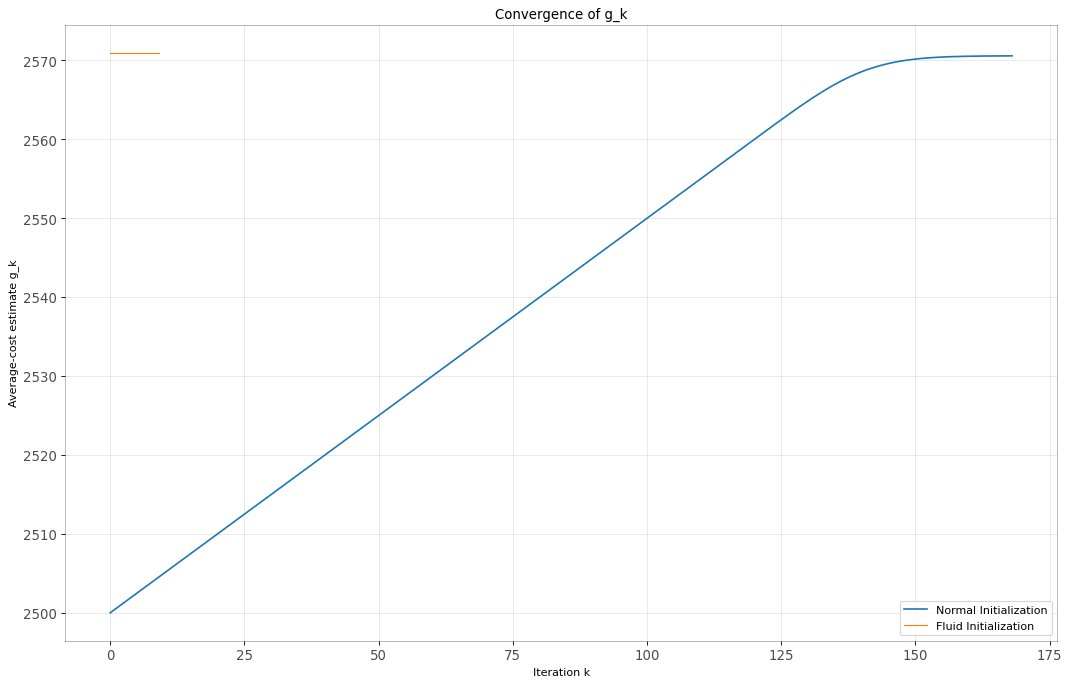

In [11]:
lam = lam_values
S_max = upper_bound_capacity
initial_fluid_array = val_fluid #- val_fluid[0]  # relative to the first capacity
stupid_initial = np.zeros(S_max+1)#np.array([-i**2 for i in range(S_max + 1)])  # 
results = value_iteration(lam, N, S_max, ref_state=0, tol=1e-2, max_iter=500, val_initial=stupid_initial)
u_policy, g_star, h_star, n_it, g_hist, h_hist, value = results
results_fluid = value_iteration(lam, N, S_max, ref_state=0, tol=1e-2, max_iter=10, val_initial=initial_fluid_array)
u_policy_fluid, g_star_fluid, h_star_fluid, n_it_fluid, g_hist_fluid, h_hist_fluid, value_fluid = results_fluid

print("=== Continuous‑control Geom/Geom/∞ queue ===")
print(f"Arrival probability λ    : {lam}")
print(f"Optimal average cost g*  : {g_star:.6f}")
print(f"Iterations to converge   : {n_it}")
print("\nOptimal control u*(x) ")
print(u_policy[:])

print(f"Optimal average cost g* (fluid value)  : {g_star_fluid:.6f}")
print(f"Iterations to converge (fluid value)   : {n_it_fluid}")
print("\nOptimal control u*(x) (fluid value):")
print(u_policy_fluid[:])

# ---------- Plot convergence of g_k ----------
plt.figure(figsize=(16,10), dpi= 80)
plt.plot(g_hist[:], marker="", fillstyle='none', label ='Normal Initialization')
plt.plot(g_hist_fluid[:], marker="", linewidth=1, label='Fluid Initialization')
plt.xlabel("Iteration k")
plt.ylabel("Average‑cost estimate g_k")
plt.title("Convergence of g_k")
plt.xticks(rotation=0, fontsize=12, horizontalalignment='center', alpha=.7)
plt.yticks(fontsize=12, alpha=.7)
plt.grid(axis='both', alpha=.3)
plt.gca().spines["top"].set_alpha(0.3)    
plt.gca().spines["bottom"].set_alpha(0.3)
plt.gca().spines["right"].set_alpha(0.3)    
plt.gca().spines["left"].set_alpha(0.3)   
plt.legend(loc = "lower right")
plt.show()

In [13]:
u_policy[30:40]/N

array([6.78598213e-12, 6.78598213e-12, 3.37828789e-04, 4.84179894e-03,
       9.03521836e-03, 1.30665341e-02, 1.69615096e-02, 2.07329256e-02,
       2.43894199e-02, 2.79381324e-02])

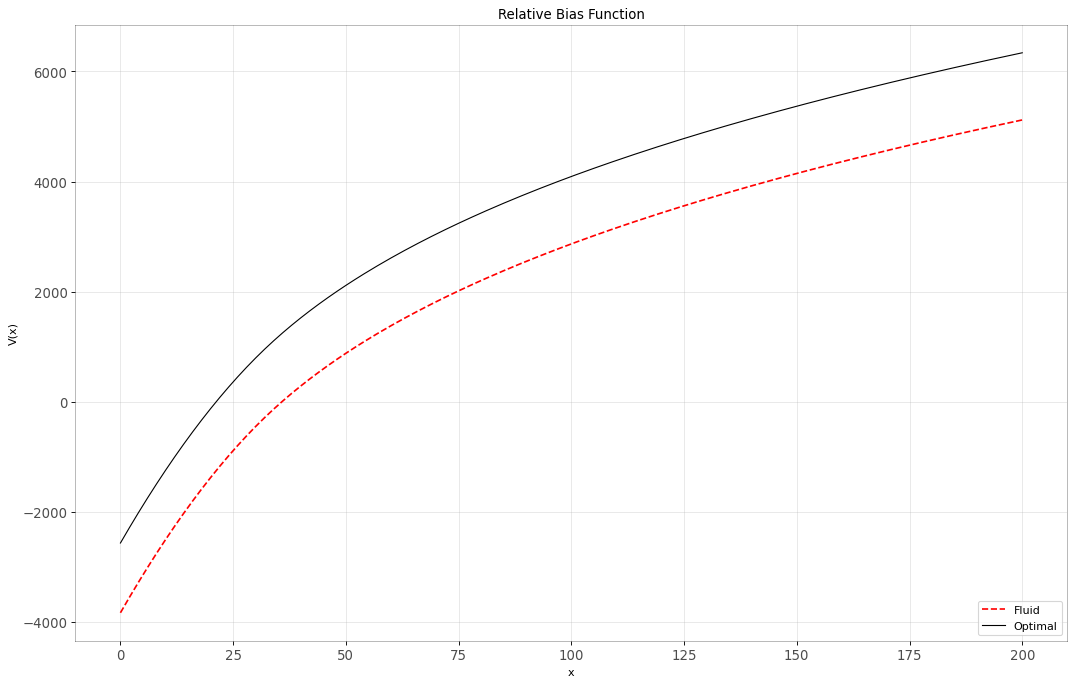

In [19]:
plt.figure(figsize=(16,10), dpi= 80)
plt.plot(val_fluid[:] - (int((1-drop_factor)*T))*stable_cost, marker="", fillstyle='none', label ='Fluid', color = 'red', linestyle='--')
#plt.plot(val_steady_control[:] - (T-1)*stable_cost, marker="", fillstyle='none', label ='Fluid Steady Control', color = 'blue')
plt.plot(h_star[:] - stable_cost, marker="", linewidth=1, label='Optimal', color = 'black')
#plt.plot(h_star[:], marker="", linewidth=1, label='Optimal value from 0', color = 'blue')
plt.xlabel("x")
plt.ylabel("V(x)")
plt.title("Relative Bias Function")
plt.xticks(rotation=0, fontsize=12, horizontalalignment='center', alpha=.7)
plt.yticks(fontsize=12, alpha=.7)
plt.grid(axis='both', alpha=.3)
plt.gca().spines["top"].set_alpha(0.3)    
plt.gca().spines["bottom"].set_alpha(0.3)
plt.gca().spines["right"].set_alpha(0.3)    
plt.gca().spines["left"].set_alpha(0.3)   
plt.legend(loc = "lower right")
plt.show()

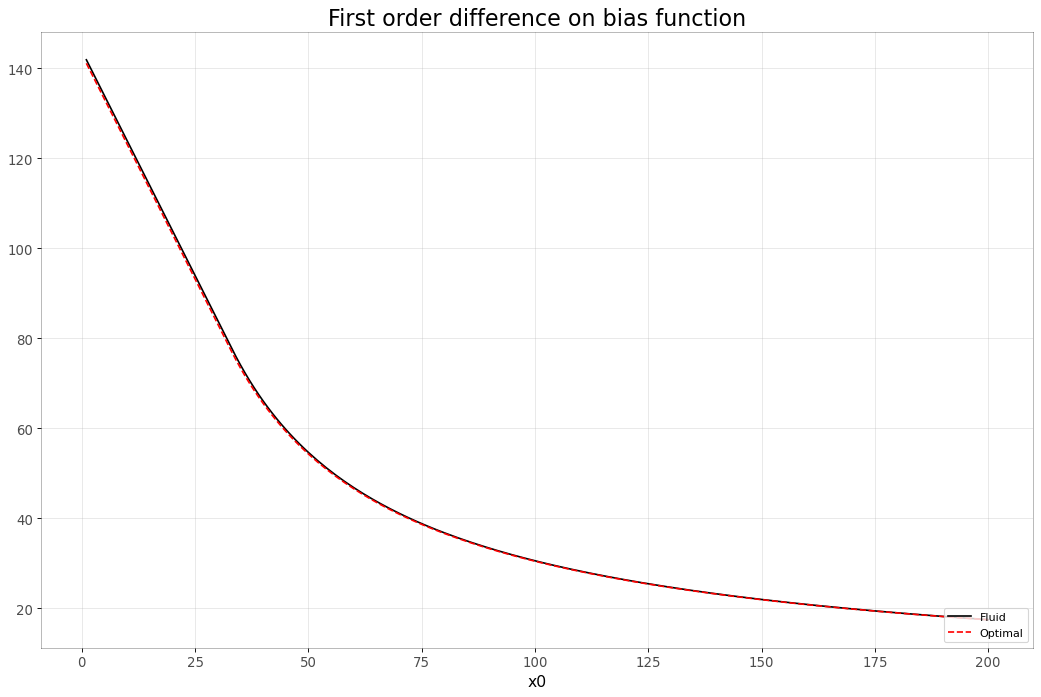

In [20]:
optimal_value = np.array(value)

line_styles = itertools.cycle(['-', '--', '-.', ':'])
colors = itertools.cycle(['black', 'red', 'blue'])
plt.figure(figsize=(16,10), dpi= 80)
x=np.arange(0, upper_bound_capacity + 1, 1)
plt.plot(x[1:], val_fluid[1:]-val_fluid[:-1], label='Fluid', linestyle=next(line_styles), marker='', fillstyle='none', color = next(colors))
plt.plot(x[1:], optimal_value[1:] - optimal_value[:-1], label='Optimal', linestyle=next(line_styles), marker='', fillstyle='none', color = next(colors))
#plt.plot(x[1:], value_temp_fluid[1:] - value_temp_fluid[:-1], label='Fluid Jumps', linestyle=next(line_styles), marker='', fillstyle='none', color = next(colors))

# Decoration
plt.xticks(rotation=0, fontsize=12, horizontalalignment='center', alpha=.7)
plt.yticks(fontsize=12, alpha=.7)
plt.title('First order difference on bias function', fontsize=20)
plt.grid(axis='both', alpha=.3)
plt.xlabel('x0', fontsize = 14)
plt.gca().spines["top"].set_alpha(0.3)    
plt.gca().spines["bottom"].set_alpha(0.3)
plt.gca().spines["right"].set_alpha(0.3)    
plt.gca().spines["left"].set_alpha(0.3)   
plt.legend(loc = "lower right")
plt.show()
plt.close()

In [24]:
lookahead_windows = [1]#, 5, 10]#, 20, 50, 100, 200]
lam = lam_values
S_max = upper_bound_capacity
initial_fluid_array = val_fluid
average_cost = np.zeros(len(lookahead_windows))
bias_function = np.zeros((len(lookahead_windows), S_max + 1))
for index, window in tqdm(enumerate(lookahead_windows)):     #- val_fluid[0]  # relative to the first capacity
    results_fluid = value_iteration(lam, N, S_max, ref_state=0, tol=1e-1, max_iter=window, val_initial=initial_fluid_array)
    u_policy_lookahead, g_star_lookahead, h_star_lookahead, n_it_lookahead, g_hist_lookahead, h_hist_lookahead, value_lookahead = results_fluid
    average_cost[index], bias_function[index, :], stationary_dist =  policy_evaluation(lam, N, S_max, u_policy_lookahead, tol=1e-12, max_iter=10000)

1it [00:00,  1.44it/s]


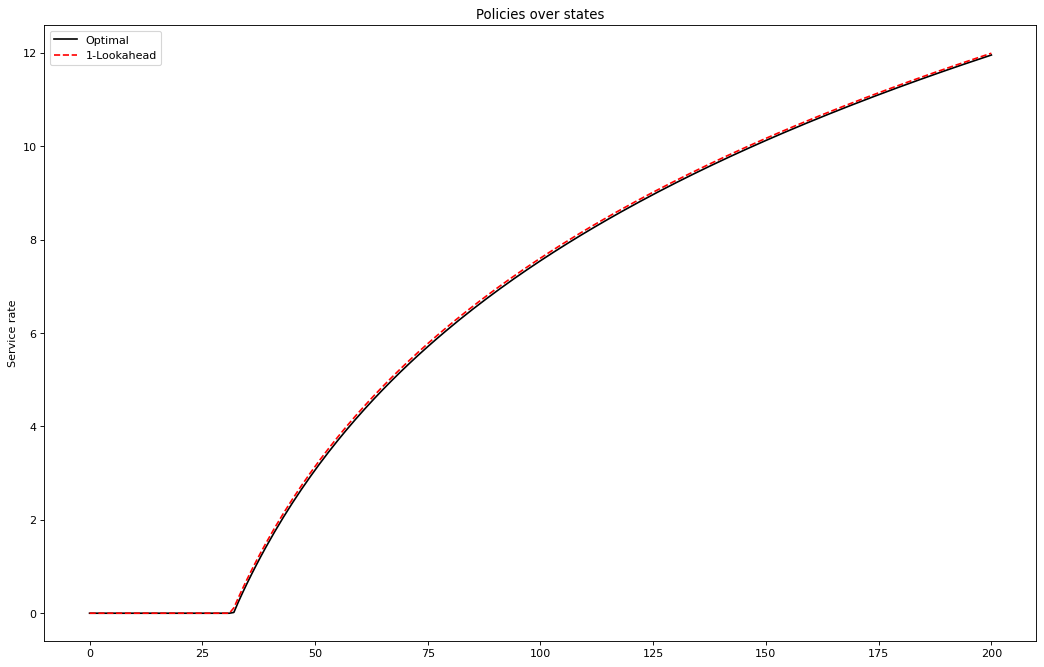

In [27]:
plt.figure(figsize=(16,10), dpi= 80)
# 1) Overlayed lines
plt.plot(capacities, u_policy, label='Optimal', color = 'black')
plt.plot(capacities, u_policy_fluid, label='1-Lookahead', linestyle='--', color = 'red')
plt.ylabel('Service rate')
plt.legend()
plt.title('Policies over states')

plt.show()

In [28]:
test_average, test_bias, test_dist = policy_evaluation(lam, N, S_max, u_policy, tol=1e-12, max_iter=10000)
np.dot(capacities, test_dist)

35.25206260376315

In [29]:
np.dot(capacities, stationary_dist)

33.49159665753558

In [30]:
average_cost

array([2570.67077912])

In [32]:
T = 1000
N_values = np.array([10, 20, 50, 70, 100]) #np.arange(10, 201, 10)lam_values = .5 
upper_bound_capacity = 200
drop_factor = 0.3
lam_values = .5
lam = lam_values
capacities = np.arange(0, S_max + 1, 1)
sub_gap = np.zeros((N_values.shape[0]))
sub_gap_proportion = np.zeros((N_values.shape[0]))
n_it_fluid = np.zeros((N_values.shape[0]))
n_it = np.zeros((N_values.shape[0]))    

for index, N in tqdm(enumerate(N_values)):
    capacities = np.arange(0, upper_bound_capacity + 1, 1)
    val_fluid = np.zeros((capacities.shape[0]))
    solution_fluid = np.zeros((capacities.shape[0], T))
    states_fluid = np.zeros((capacities.shape[0], T+1))
    val_fluid_temp = np.zeros((capacities.shape[0]))


    for indx_cap, x in tqdm(enumerate(capacities)):
        val_fluid_temp[indx_cap], solution_fluid[indx_cap, :], states_fluid[indx_cap, : ] = fluid_value(T, N, lam_values, x)
        val_fluid[indx_cap] = fluid_value_eval(T, N, lam_values, x, solution_fluid[indx_cap, :], states_fluid[indx_cap, :], drop = drop_factor)
    
    S_max = upper_bound_capacity
    initial_fluid_array = val_fluid 
    stupid_initial = np.zeros(S_max+1)
    results = value_iteration(lam, N, S_max, ref_state=0, tol=1e-2, max_iter=500, val_initial=stupid_initial)
    u_policy, g_star, h_star, n_it, g_hist, h_hist, value = results
    
    initial_fluid_array = val_fluid
    bias_function = np.zeros((S_max + 1))

    results_fluid = value_iteration(lam, N, S_max, ref_state=0, tol=1e-1, max_iter=1, val_initial=initial_fluid_array)
    u_policy_lookahead, g_star_lookahead, h_star_lookahead, n_it_lookahead, g_hist_lookahead, h_hist_lookahead, value_lookahead = results_fluid
    average_cost, bias_function[:], stationary_dist =  policy_evaluation(lam, N, S_max, u_policy_lookahead, tol=1e-12, max_iter=10000)

    sub_gap[index] = average_cost - g_star
    sub_gap_proportion[index] = sub_gap[index]/g_star


201it [02:10,  1.54it/s]
201it [02:21,  1.42it/s]
201it [02:09,  1.55it/s]
201it [02:20,  1.43it/s]
201it [03:14,  1.03it/s]
5it [55:21, 664.36s/it]


In [34]:
sub_gap_proportion = np.zeros((N_values.shape[0]))
for index, N in tqdm(enumerate(N_values)):
    g_star = (N+ np.sqrt(lam))**2
    sub_gap_proportion[index] = np.abs(sub_gap[index])/g_star

5it [00:00, ?it/s]


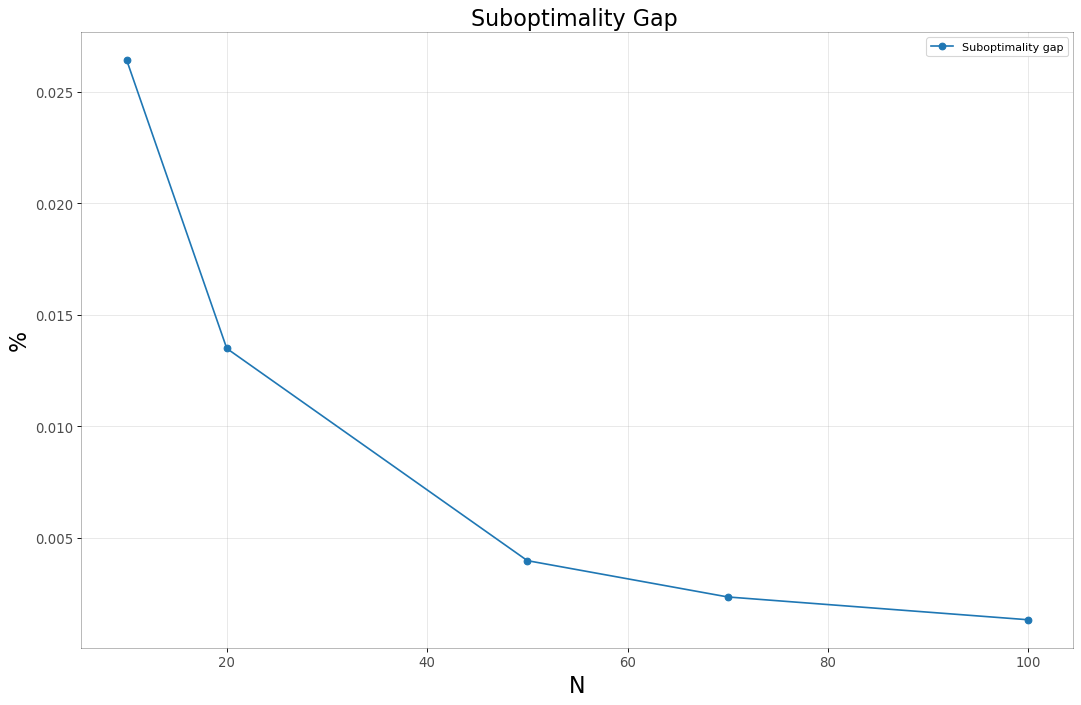

In [42]:
plt.figure(figsize=(16,10), dpi= 80)
plt.plot(N_values,sub_gap_proportion*100, label='Suboptimality gap', marker='o')

# Decoration
plt.xticks(rotation=0, fontsize=12, horizontalalignment='center', alpha=.7)
plt.yticks(fontsize=12, alpha=.7)
plt.title('Suboptimality Gap ', fontsize=20)
plt.grid(axis='both', alpha=.3)
plt.xlabel('N', fontsize = 20)
plt.ylabel('%', fontsize = 20)
plt.gca().spines["top"].set_alpha(0.3)    
plt.gca().spines["bottom"].set_alpha(0.3)
plt.gca().spines["right"].set_alpha(0.3)    
plt.gca().spines["left"].set_alpha(0.3)   
plt.legend(loc = "upper right")
plt.show()
plt.close()

=== Continuous‑control Geom/Geom/∞ queue ===
Arrival probability λ    : 0.5
Optimal average cost g*  : 114.131741
Iterations to converge   : 67

Optimal control u*(x) for x=0..20:
[0.     0.     0.     0.     0.     0.     0.026  0.0633 0.0942 0.1205
 0.1434 0.1636 0.1817 0.1981 0.213  0.2267 0.2394 0.2511 0.262  0.2723
 0.2819]
Optimal average cost g* (fluid value)  : 114.131743
Iterations to converge (fluid value)   : 50

Optimal control u*(x) for x=0..20 (fluid value):
[0.     0.     0.     0.     0.     0.     0.026  0.0633 0.0942 0.1205
 0.1434 0.1636 0.1817 0.1981 0.213  0.2267 0.2394 0.2511 0.262  0.2723
 0.2819]


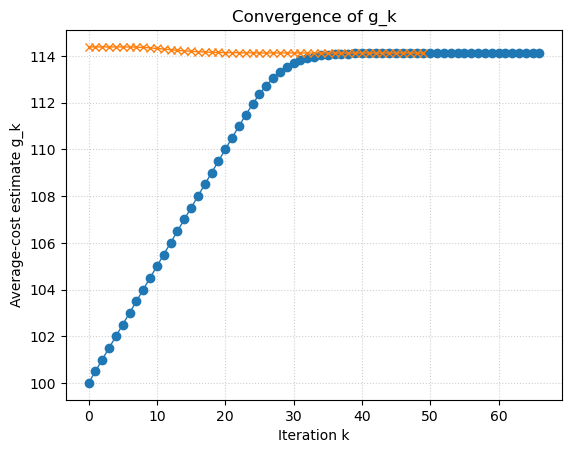

In [148]:
from __future__ import annotations
import math
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, List

################################################################################
# Relative cost iteration with *continuous* control + history
################################################################################

def relative_cost_iteration_continuous(
    lam: float,
    N: float,
    S_max: int,
    tol: float = 1e-8,
    max_iter: int = 20_000,
    ref_state: int | None = 0,
    val_fluid: np.ndarray | None = None
) -> Tuple[np.ndarray, float, np.ndarray, int, List[float], List[np.ndarray], np.ndarray]:
    """Differential cost iteration (continuous control) **with history**.

    Returns `u_star, g, h, it, g_hist, h_hist` where:
    * `g_hist[k]   = g_k` average‑cost estimate at iteration *k*;
    * `h_hist[k]   = h_k` differential cost **vector** at iteration *k*.
    """
    if not (0 < lam < 1):
        raise ValueError("λ must be in (0,1).")
    if ref_state is None:
        ref_state = 0

    S = S_max + 1
    value = val_fluid if val_fluid is not None else np.zeros(S)  # initial value function
    h = val_fluid - val_fluid[ref_state] if val_fluid is not None else np.zeros(S)  # differential cost vector
    g = 0.0
    u_star = np.zeros(S)

    # --- history containers ---
    g_hist: List[float] = []
    h_hist: List[np.ndarray] = []

    # Pre‑compute binomial coefficients
    Cnk = build_binom_tables(S_max)
    eps_u = 1e-10  # guard against u→1


    for it in range(1, max_iter + 1):
        value_new = np.zeros(S)  # new differential cost vector

        # ----- Bellman minimisation over u ∈ [0,1) for each x -----
        for x in range(S):
            def Q(u: float) -> float:
                one_minus_u = 1.0 - u
                inv_one_minus_u = N ** 2 / one_minus_u  # part of cost plus exp terms

                # Expected continuation cost
                pow_u = 1.0  # u^d incrementally
                exp_val = 0.0
                for d in range(x + 1):
                    if d > 0:
                        pow_u *= u
                    prob = Cnk[x][d] * pow_u * (one_minus_u ** (x - d))
                    idx_arr1 = min(x + 1 - d, S_max)  # arrival=1
                    idx_arr0 = x - d                  # arrival=0
                    exp_val += prob * (lam * h[idx_arr1] + (1 - lam) * h[idx_arr0])
                return inv_one_minus_u + x  + exp_val

            u_opt, q_val = golden_section_minimize(Q, 0.0, 1.0 - eps_u)
            u_star[x] = u_opt
            value_new[x] = q_val

        # ----- Average‑cost update and normalisation -----
        g_new = value_new[ref_state] 
        h_new = value_new - value_new[ref_state]

        # ----- Save history -----
        g_hist.append(g_new)
        h_hist.append(h_new.copy())

        # ----- Convergence test -----
        if max(abs(g_new - g), np.max(np.abs(h_new - h))) < tol:
            h = h_new
            g = g_new
            break

        h = h_new
        g = g_new
    else:
        it = max_iter

    return u_star, g, h, it, g_hist, h_hist

################################################################################
# Demonstration + plotting
################################################################################


results = relative_cost_iteration_continuous(lam, N, S_max, ref_state=0, tol=1e-6,max_iter=20_000)
u_policy, g_star, h_star, n_it, g_hist, h_hist = results
results_fluid = relative_cost_iteration_continuous(lam, N, S_max, ref_state=0, tol=1e-6,max_iter=20_000, val_fluid=val_fluid)
u_policy_fluid, g_star_fluid, h_star_fluid, n_it_fluid, g_hist_fluid, h_hist_fluid = results_fluid

print("=== Continuous‑control Geom/Geom/∞ queue ===")
print(f"Arrival probability λ    : {lam}")
print(f"Optimal average cost g*  : {g_star:.6f}")
print(f"Iterations to converge   : {n_it}")
print("\nOptimal control u*(x) for x=0..20:")
print(np.round(u_policy[:21], 4))

print(f"Optimal average cost g* (fluid value)  : {g_star_fluid:.6f}")
print(f"Iterations to converge (fluid value)   : {n_it_fluid}")
print("\nOptimal control u*(x) for x=0..20 (fluid value):")
print(np.round(u_policy_fluid[:21], 4))

# ---------- Plot convergence of g_k ----------
plt.figure()
plt.plot(g_hist, marker="o", linewidth=1)
plt.plot(g_hist_fluid, marker="x", linewidth=1, label='Fluid value')
plt.xlabel("Iteration k")
plt.ylabel("Average‑cost estimate g_k")
plt.title("Convergence of g_k")
plt.grid(True, linestyle=":", alpha=0.6)

plt.show()

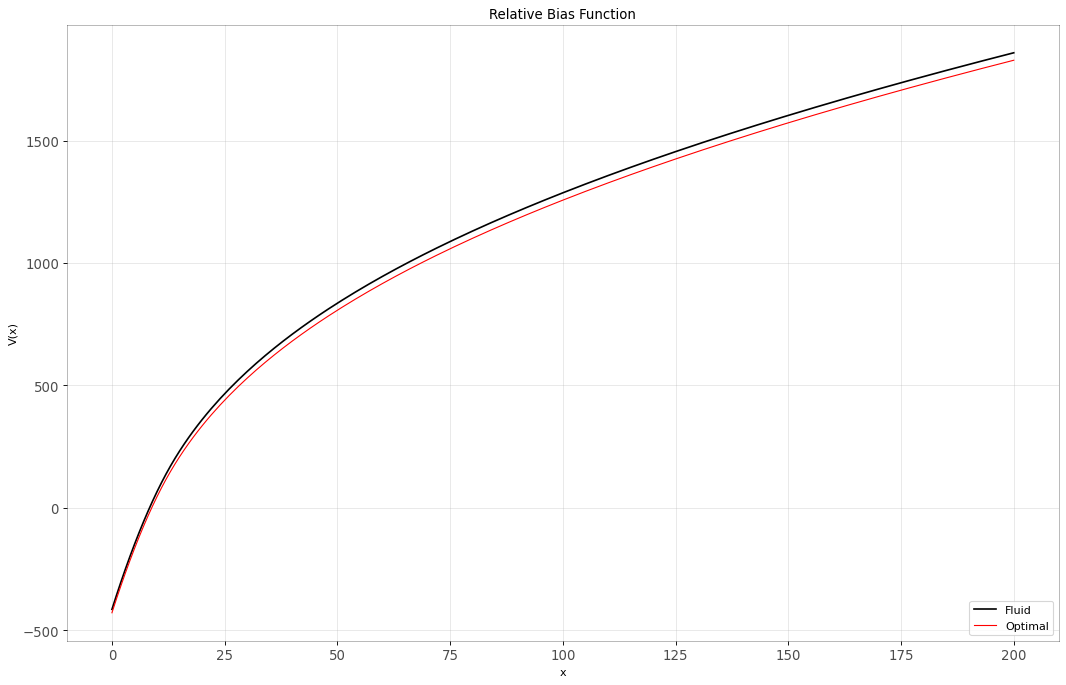

In [53]:
plt.figure(figsize=(16,10), dpi= 80)
plt.plot(val_fluid[:] - (T-1)*stable_cost, marker="", fillstyle='none', label ='Fluid', color = 'black')
#plt.plot(val_steady_control[:] - (T-1)*stable_cost, marker="", fillstyle='none', label ='Fluid Steady Control', color = 'blue')
plt.plot(h_star[:] + h_star[0] - stable_cost, marker="", linewidth=1, label='Optimal', color = 'red')
#plt.plot(h_star[:], marker="", linewidth=1, label='Optimal value from 0', color = 'blue')
plt.xlabel("x")
plt.ylabel("V(x)")
plt.title("Relative Bias Function")
plt.xticks(rotation=0, fontsize=12, horizontalalignment='center', alpha=.7)
plt.yticks(fontsize=12, alpha=.7)
plt.grid(axis='both', alpha=.3)
plt.gca().spines["top"].set_alpha(0.3)    
plt.gca().spines["bottom"].set_alpha(0.3)
plt.gca().spines["right"].set_alpha(0.3)    
plt.gca().spines["left"].set_alpha(0.3)   
plt.legend(loc = "lower right")
plt.show()